In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import pickle
import os

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import utils

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder

# Extract features from images with VGG16

In [55]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Load training data and put in in array

In [57]:
img_arr = []
filename_list = []
path_train_data = "../../tiles2/"
for file in os.listdir(path_train_data):
    if int(file.split(".")[0][4:])>1016:
        img = plt.imread(os.path.join(path_train_data,file))
        assert(img.shape==(256,256,3))
        filename_list.append(path_train_data+file)
        img_arr.append(img)
images = np.asarray(img_arr)
print(images.shape)

(1383, 256, 256, 3)


In [58]:
np.save("filenames_tiles2.npy", np.asarray(filename_list))

In [60]:
pickle.dump(images, open("imgages.pkl", "wb"), protocol=2)

### Feed in Vgg16 model to extract features

In [ ]:
img_data = preprocess_input(images.astype(np.float))
vgg16_feature = model.predict(img_data)
np.save("features_tiles2.npy", vgg16_feature)
# np.save("filenames_tiles.npy", np.asarray(filename_list))

### Helper functions

In [80]:
def show_results(path, filenames, preds):
    for pred in np.unique(preds):
        print("PREDICTED LABEL:", pred)
        files = filenames[np.asarray(preds)==pred]
        some_files = np.random.choice(files, 5)
        for f in some_files:
            img = plt.imread(os.path.join(path, f))
            plt.imshow(img)
            plt.show()
            
def img_to_feature(img_path, show_image=True):
    img = plt.imread(img_path)
    if show_image:
        plt.imshow(img[:,:,:3])
        plt.show()
    img_new = np.expand_dims(img[:,:,:3], axis=0)
    # print(type(img_data))
    img_data = img_new.copy().astype(float)
    img_data = preprocess_input(img_data)
    vgg16_feature = model.predict(img_data)
    img_feature = np.reshape(vgg16_feature, (1,-1))
    return img_feature

## Predict water images seperately: 

Water 2329


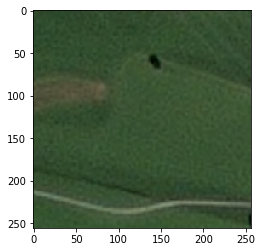

In [102]:
water_dic = {}
threeshold = 20000
for i in range(2000, 2400):
    filepath = '../../tiles2/tile{}.jpg'.format(i)
    if os.path.exists(filepath):
        image = plt.imread(filepath)
        r_low = image[:, :, 2] < 50
        r_high = image[:, :, 2] >= 20
        g_low = image[:, :, 1] < 100
        g_high = image[:, :, 1] >= 70
        b_low = image[:, :, 0] < 80
        b_high = image[:, :, 0] >= 50

        total = np.sum(np.logical_and(np.logical_and(np.logical_and(r_low, r_high), np.logical_and(g_low, g_high)),
                                      np.logical_and(b_low, b_high)))

        if total > threeshold:
            print("Water", i)
            plt.imshow(image)
            plt.show()
            water_dic[filepath] = "water"

# Train and test kmeans clustering

* Extract features with VGG network (for training, this step is done on the cluster and the outputs are just loaded here)
* Apply pca on the feature vector
* Fit Kmeans

### Fit training data

In [103]:
# Hyperparameters
n_comps = 20
n_clusters = 10

In [73]:
path1 = "../../tiles/"
path2 = "../../tiles2/"
filenames_tiles1 = np.load("../../filenames_tiles.npy")
filenames_tiles1 = np.asarray([path1+f for f in filenames_tiles1])
filenames_tiles2 = np.load("../../filenames_tiles2.npy")
filenames_tiles2 = np.asarray([path2+f for f in filenames_tiles2.astype(str)])
filenames_tiles3 = np.load("filenames_tiles3.npy")
filenames = np.concatenate((filenames_tiles1, filenames_tiles2, filenames_tiles3), axis=0)
assert(len(filenames)==len(np.unique(filenames)))
# filenames[:512] = [path1+f for f in filenames[:512]]
print(filenames)
print(filenames.shape)
features1 = np.load("../../features_tiles.npy")
features2 = np.load("../../features_tiles2.npy")
features3 = np.load("../../features_tiles3.npy")
features = np.concatenate((features1, features2, features3), axis=0)
print(features.shape)
assert(len(filenames) == len(features))

['../../tiles/tile288.jpg' '../../tiles/tile18.jpg'
 '../../tiles/tile539.jpg' ... '../../tiles2/tile1853.jpg'
 '../../tiles2/tile1847.jpg' '../../tiles2/tile2396.jpg']
(2641,)
(2641, 8, 8, 512)


In [104]:
pca = PCA(n_components=n_comps)
kmeans = KMeans(n_clusters=n_clusters, init="random")

data = np.reshape(features,(len(features),-1))
data_mean = np.mean(data)
data_std = np.std(data)
norm_data = (data-data_mean)/data_std
print(np.mean(norm_data))

# pca
transformed = pca.fit_transform(data)
print("explained_var:", sum(pca.explained_variance_ratio_))

# kmeans
kmeans.fit(transformed)
preds = kmeans.labels_

-2.3202813e-07
explained_var: 0.1519369683228433


### Show outputs

PREDICTED LABEL: 0


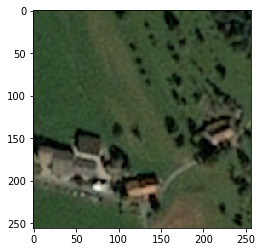

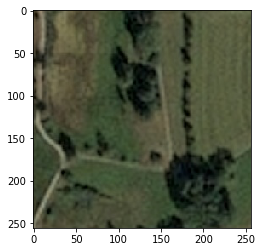

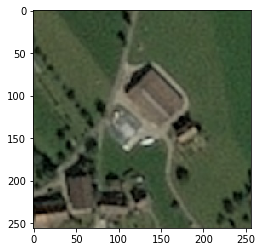

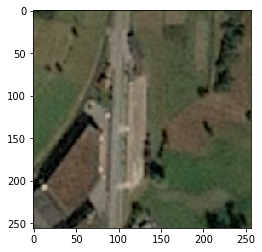

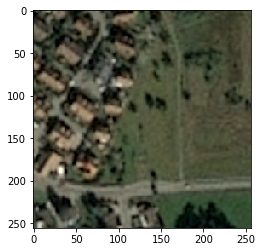

PREDICTED LABEL: 1


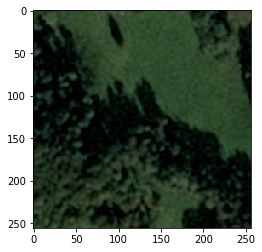

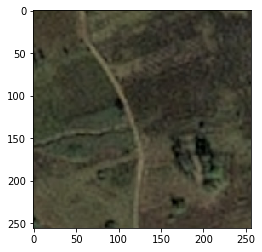

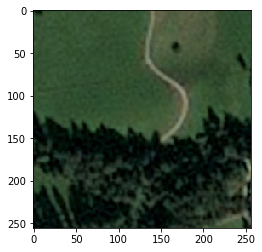

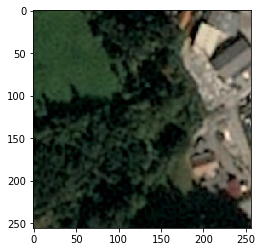

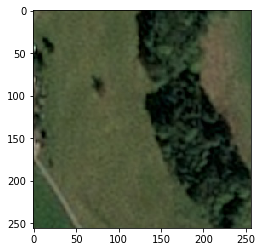

PREDICTED LABEL: 2


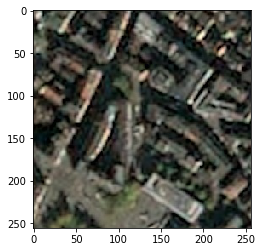

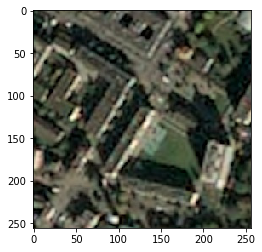

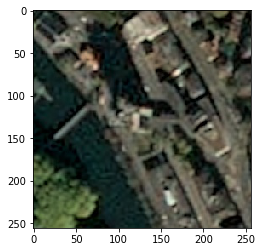

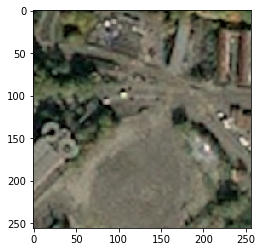

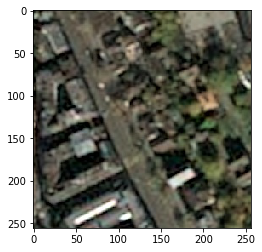

PREDICTED LABEL: 3


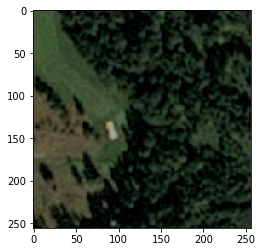

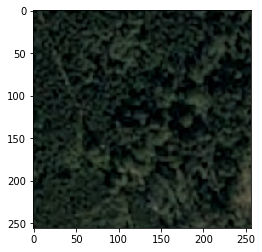

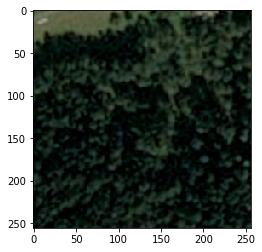

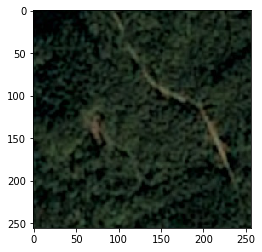

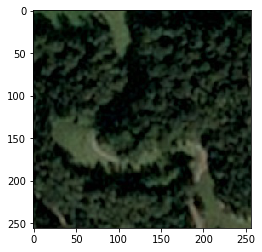

PREDICTED LABEL: 4


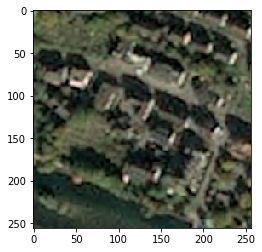

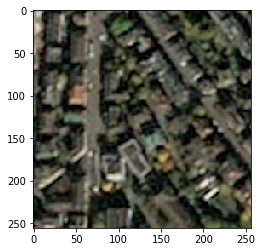

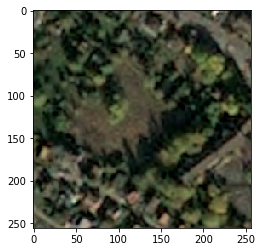

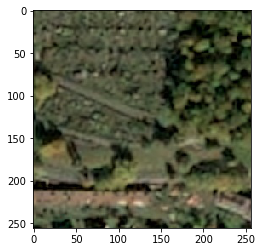

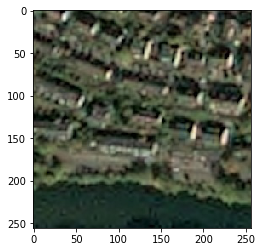

PREDICTED LABEL: 5


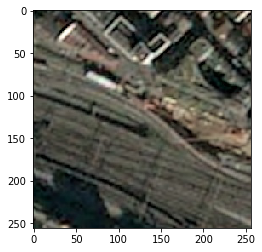

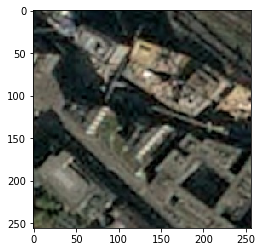

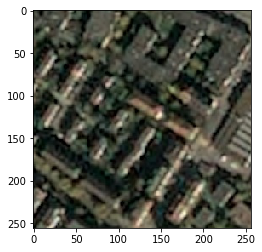

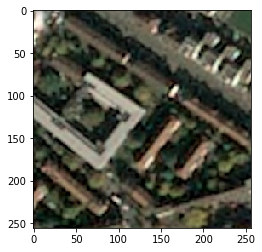

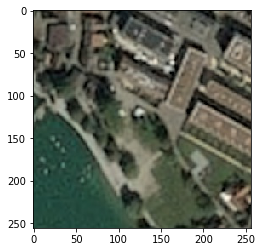

PREDICTED LABEL: 6


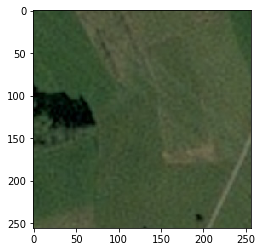

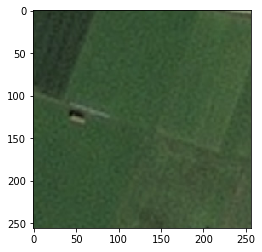

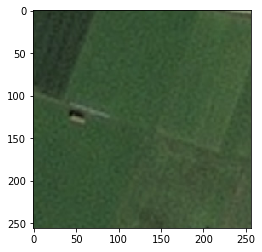

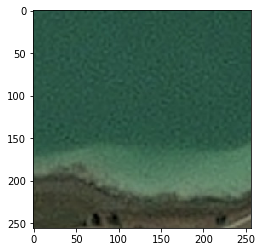

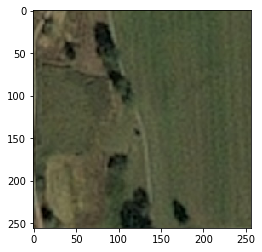

PREDICTED LABEL: 7


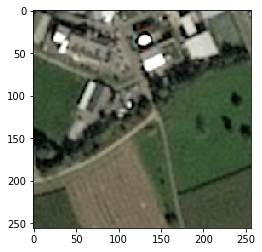

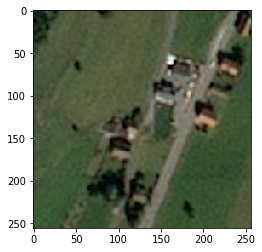

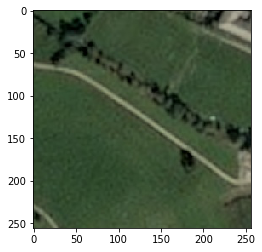

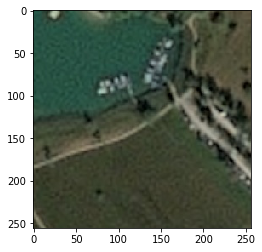

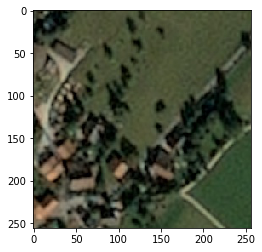

PREDICTED LABEL: 8


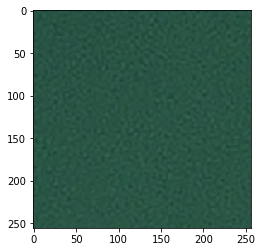

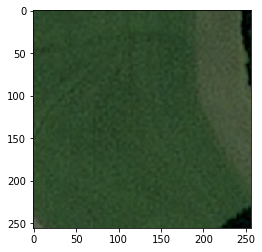

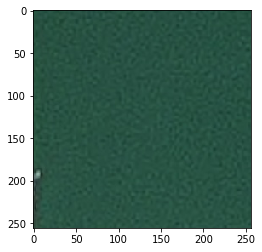

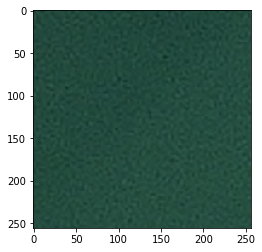

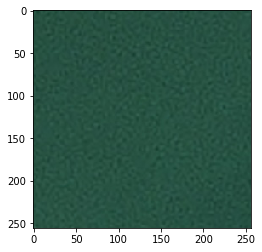

PREDICTED LABEL: 9


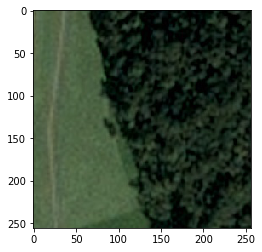

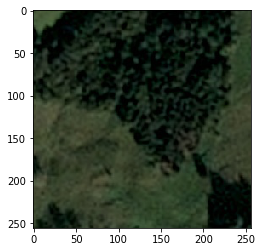

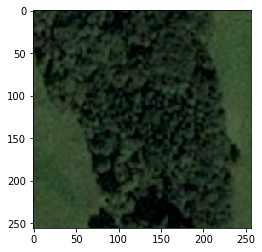

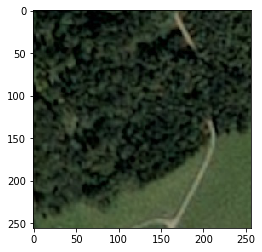

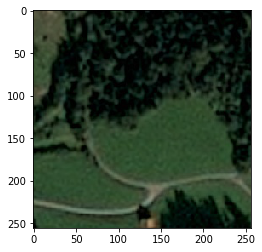

In [105]:
show_results("", filenames, preds)

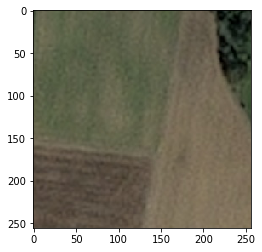

In [90]:
img = plt.imread("../../tiles2/tile8.jpg")
plt.imshow(img)
plt.show()

### Build labels dictionary: 
For the classes that are output of kmeans clustering, decide which ones belong to which kind of habitat

In [106]:
assignments = {0:"houses_fields", 1:"grass", 2:"city", 3:"forest", 4:"suburb", 5:"city", 6:"field", 7:"houses_fields", 8:"water", 9:"forest-grass"}
# assignments = {0:"field", 1:"city", 2:"forest", 3:"suburb"}

### save the output labels:

In [107]:
output_dic = {filenames[i]:assignments[kmeans.labels_[i]] for i in range(len(filenames))}

In [109]:
print(len(output_dic.keys()))

2641


In [110]:
json.dump(output_dic, open("labels_dic.json", "w"))

## Process new data:
* A new data example is compared to all cluster centers to find the closest one.
* The new data then gets the label of its closes cluster

In [ ]:
test_path = "../../tiles"
out_labels = {}
for f in os.listdir(test_path)[:2]:
    # extract features
    features = img_to_feature(os.path.join(test_path, f), show_image=False)
    data = np.reshape(features,(len(features),-1))
    # print(data.shape)
    # normalize, apply pca
    norm_data = (data-data_mean)/data_std
    transformed = pca.transform(data)
    # find closest kmeans cluster
    dist = []
    for center in kmeans.cluster_centers_:
        dist.append(np.linalg.norm(center-transformed))
    # print("predicted label:", assignments[np.argmin(dist)])
    # put (filename:predicted) class in dictionary
    out_labels[f] = assignments[np.argmin(dist)]
print(out_labels)

# Train deep learning model with labels (moved this part to .py file)

In [53]:
from tensorflow.keras import layers

### Prepare data

In [ ]:
# print(images.shape)
# img_data = preprocess_input(images.astype(np.float))
# print(img_data.shape)


labels = [assignments[kmeans.labels_[i]] for i in range(len(filename_list))]
def one_hot(labels):
    """ one hot encoding for labels"""
    #dataframe = self.cf
    unique  = np.unique(labels).tolist()
    one_hot_labels = np.zeros((len(labels), len(unique)))
    for i in range(len(labels)):
        #print(cf.iloc[i,loc])
        pitch = labels[i]
        ind = unique.index(pitch)
        one_hot_labels[i, ind] = 1
    return one_hot_labels, unique

labels_one_hot = one_hot(np.asarray(labels))
labs = [0 if l is "city" else 1 for l in labels]

# print(labels_one_hot)

### Train model

In [ ]:
model.trainable = False
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(2,activation='softmax')
pred_model = tf.keras.Sequential([
  model,
  global_average_layer,
  prediction_layer
])

pred_model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
pred_model.summary()

In [ ]:
print(img_data.shape, np.asarray(labs).shape)
# labs_onehot= utils.to_categorical(labs)
history = pred_model.fit(x = img_data, y= np.asarray(labs),
                    epochs=100, 
                    steps_per_epoch=2)

# Correct wrong labels:

In [ ]:
# counter = 0
for file in sorted(output_dic.keys())[1800:1900]:
    print("label:", output_dic[file])
    img = plt.imread(file)
    print(file)
    plt.imshow(img)
    plt.show()
    # correct = input("correct? then click enter, else press some other key and enter")
    # counter+=1
    # if correct:
    #     actual_label = input("actual label")
    #     print(actual_label)
    #     output_dic[file] = actual_label

# Compare the output labels of different labels

In [131]:
labels1 = json.load(open("1-17_pred_labels.json", "r"))
labels2 = json.load(open("1-17_pred_labels_v2.json", "r"))

In [ ]:
img = plt.imread("../../1-17.tif")
img.shape

In [ ]:
keys1 = sorted(labels1.keys())
keys2 = sorted(labels2.keys())
assert(len(keys1)==len(keys2))
for i in range(len(keys1)):
    key = keys1[i]
    
    if labels1[key]!=labels2[key]:
        print("new model:", labels1[key])
        print("old model:", labels2[key])
        print(key)
        key_list = key.split("_")
        i = int(key_list[1])
        j = int(key_list[2])
        tile = img[i:i + 256, j:j + 256, :]
        plt.imshow(tile)
        plt.show()
        print(" ")